In [32]:
import h5py
import os
import numpy as np

In [37]:
ref_folder = r'\\10.245.74.158\Chromatin_NAS_0\Hi-C\sn3Cseq\2019_human_cortex\Interaction\Human_single_cell_10kb_cool'

In [38]:
matched_files = [os.path.join(ref_folder, _fl) for _fl in os.listdir(ref_folder) if '.cool' in _fl]

In [39]:
matched_files[0]

'\\\\10.245.74.158\\Chromatin_NAS_0\\Hi-C\\sn3Cseq\\2019_human_cortex\\Interaction\\Human_single_cell_10kb_cool\\181218_21yr_2_A10_AD001_L23_10kb_contacts.cool'

In [43]:
with h5py.File(matched_files[0]) as _f:
    print(_f.keys())
    print(_f['pixels'].keys())
    print(_f['pixels']['count'][:].shape)

<KeysViewHDF5 ['bins', 'chroms', 'indexes', 'pixels']>
<KeysViewHDF5 ['bin1_id', 'bin2_id', 'count']>
(298057,)


In [44]:
cluster_ref_folder = r'\\10.245.74.158\Chromatin_NAS_0\Hi-C\sn3Cseq\2019_human_cortex\Interaction\Human_cluster_mcool'

In [45]:
matched_cluster_files = [os.path.join(cluster_ref_folder, _fl) for _fl in os.listdir(cluster_ref_folder) if '.mcool' in _fl]

In [60]:
_fl = matched_cluster_files[0]
sel_resolution = 100000

print(_fl)
with h5py.File(_fl) as _f:
    print(_f['resolutions'][str(sel_resolution)]['pixels'].keys())
    _starts = _f['resolutions'][str(sel_resolution)]['bins']['start'][:]
    _ends = _f['resolutions'][str(sel_resolution)]['bins']['end'][:]
    _chroms = _f['resolutions'][str(sel_resolution)]['bins']['chrom'][:]
    _weights = _f['resolutions'][str(sel_resolution)]['bins']['weight'][:]
    chrom_lens = _f['resolutions'][str(sel_resolution)]['chroms']['length'][:]
    chrom_names = _f['resolutions'][str(sel_resolution)]['chroms']['name'][:]
    indexes = _f['resolutions'][str(sel_resolution)]['indexes']['bin1_offset'][:]#, 'chrom_offset'][:]
    bin1_ids = _f['resolutions'][str(sel_resolution)]['pixels']['bin1_id'][:]
    bin2_ids = _f['resolutions'][str(sel_resolution)]['pixels']['bin2_id'][:]
    counts = _f['resolutions'][str(sel_resolution)]['pixels']['count'][:]
    #pixels = _f['resolutions'][str(sel_resolution)]['pixels'][:]
    

\\10.245.74.158\Chromatin_NAS_0\Hi-C\sn3Cseq\2019_human_cortex\Interaction\Human_cluster_mcool\Astro_all_brain.txt_1kb_contacts.mcool
<KeysViewHDF5 ['bin1_id', 'bin2_id', 'count']>


In [98]:
chrom_names

array([b'chr1', b'chr2', b'chr3', b'chr4', b'chr5', b'chr6', b'chr7',
       b'chr8', b'chr9', b'chr10', b'chr11', b'chr12', b'chr13', b'chr14',
       b'chr15', b'chr16', b'chr17', b'chr18', b'chr19', b'chr20',
       b'chr21', b'chr22', b'chrX', b'chrY', b'chrM'], dtype='|S5')

In [107]:
chr_2_num_bins = {_chr.decode():int(np.ceil(_len/sel_resolution)) for _chr, _len in zip(chrom_names, chrom_lens) }

2493

In [101]:
np.ceil(chrom_lens/sel_resolution).sum()

30971.0

In [102]:
len(_starts)

30971

In [119]:
from tqdm import tqdm

In [65]:
from scipy.sparse import coo_array
sps_count_array = coo_array((counts, (bin1_ids, bin2_ids)), shape=(len(_starts),len(_starts)) )

In [92]:
%%timeit
sps_count_array.getrow(1).getcol(1).toarray()

2.78 s ± 4.35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [64]:
_ends[bin1_ids] - _starts[bin1_ids]



array([100000, 100000, 100000, ..., 100000, 100000,  16571])

In [118]:
# fit default model
fit_distances, fit_counts = [], []
for _diag in np.arange(1, max(list(chr_2_num_bins.values()))):
    #print(_diag)
    _diag_vector = sps_count_array.diagonal(_diag)
    # start diff
    _start_vector = _starts[_diag:] - _starts[:-_diag]
    _kept_flags = _start_vector == sel_resolution * _diag
    _mean_count = np.mean(_diag_vector[_kept_flags])
    
    #
    fit_distances.append(sel_resolution * _diag)
    fit_counts.append(_mean_count)
    #
    

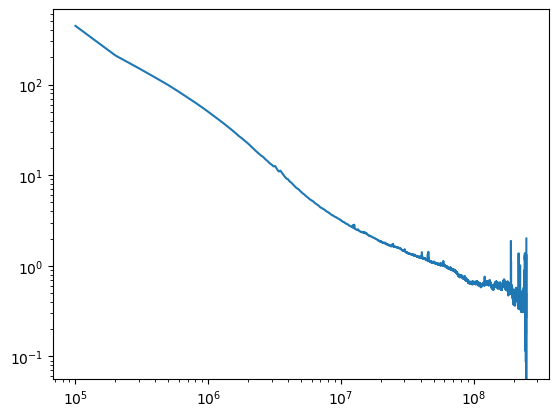

In [122]:
plt.figure()
plt.plot(fit_distances, fit_counts)
plt.yscale('log')
plt.xscale('log')

In [116]:
_mean_count

445.3660570025205

In [114]:
np.mean(_kept_flags)

0.9992250565062964

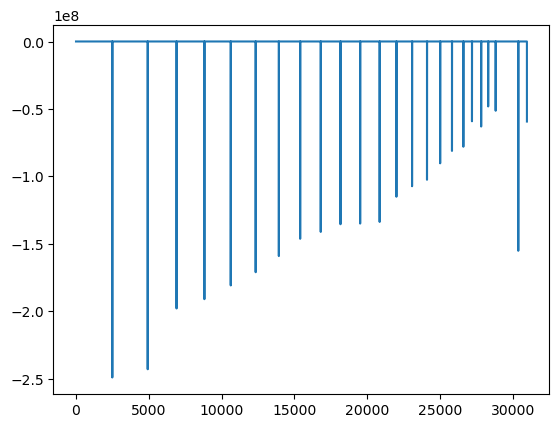

In [96]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(_starts[1:] - _starts[:-1])

array([0, 1, 0, ..., 0, 0, 0])

In [25]:
import pandas as pd

In [26]:
methylation_folder = r'\\10.245.74.158\Chromatin_NAS_0\Hi-C\sn3Cseq\2019_human_cortex\Methylation\Combined_cluster_allc'

In [29]:
astro_df = pd.read_csv(os.path.join(methylation_folder, 'allc_Astro.tsv'), delimiter='\t', low_memory=False)

In [34]:
np.unique(astro_df['7'])

array(['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19',
       '2', '20', '21', '22', '3', '4', '5', '6', '7', '8', '9', 'X'],
      dtype=object)

In [35]:
astro_df

,7,10005,+,CCC,0,2,1
0,7,10006,+,CCT,0,2,1
1,7,10007,+,CTA,0,2,1
2,7,10011,+,CCC,0,2,1
3,7,10012,+,CCT,0,2,1
4,7,10013,+,CTA,0,2,1
...,...,...,...,...,...,...,...
1130412791,21,48119876,-,CCT,0,1,1
1130412792,21,48119877,-,CCC,0,1,1
1130412793,21,48119881,-,CTA,0,1,1
1130412794,21,48119882,-,CCT,0,1,1
